In [1]:
from fact.io import read_h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
test = read_h5py("data/gamma_test_dl3.hdf5", key="events")
crab = read_h5py("data/open_crab_sample_dl3.hdf5", key="events")

gamma_test = test["gamma_prediction"] >= 0.8
gamma_crab = crab["gamma_prediction"] >= 0.8

theta2_s = crab["theta_deg"][gamma_crab].to_numpy()**2
theta2_bg = crab[["theta_deg_off_1","theta_deg_off_2","theta_deg_off_3","theta_deg_off_4","theta_deg_off_5"]][gamma_crab].to_numpy().flatten()**2
print(theta2_bg)

[2.22590251 2.31385265 1.36319884 ... 0.81825774 1.98526513 3.75594856]


[391 278 213 158 131 121  97  98 107 108  98  91  73  95  89  91  84  95
  80  84]


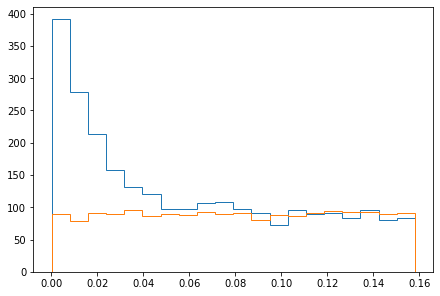

In [3]:
hist_s, bins_s = np.histogram(theta2_s[theta2_s<=np.sqrt(0.025)], bins=20)
hist_bg, bins_bg = np.histogram(theta2_bg[theta2_bg<=np.sqrt(0.025)], bins=20)
print(hist_s)

fig, ax = plt.subplots(constrained_layout=True)

ax.stairs(hist_s,bins_s)
ax.stairs(hist_bg/5,bins_bg)

#ax.hist(theta2_s[theta2_s<=0.025], bins=20, histtype="step")
#ax.hist(theta2_bg[theta2_bg<=0.025], bins=20, histtype="step")


plt.show()

In [4]:
N_on = len(theta2_s[theta2_s<=np.sqrt(0.025)])
N_off = len(theta2_bg[theta2_bg<=np.sqrt(0.025)])
print(N_on,N_off)

alpha = 0.2

S = np.sqrt(2) * np.sqrt(N_on * np.log( (1+alpha)/alpha * N_on/(N_on + N_off)) + N_off * np.log((1+alpha) * N_off/(N_on + N_off)))
S

2582 8916


15.989754417879428

In [8]:
E_true = test["corsika_event_header_total_energy"][gamma_test].to_numpy()
E_pred = test["gamma_energy_prediction"][gamma_test].to_numpy()
print(len(E_pred),len(E_true)) # show no. of events

bins_true=np.logspace(np.log10(600),np.log10(15000),21)
bins_pred=np.logspace(np.log10(600),np.log10(15000),41)

bins_true = np.append(0,bins_true)
bins_true = np.append(bins_true,np.inf)
bins_pred = np.append(0,bins_pred)
bins_pred = np.append(bins_pred,np.inf)


hist_E_true, bins_E_true = np.histogram(E_true, bins_true)
hist_E_pred, bins_E_pred = np.histogram(E_pred, bins_pred)

print(np.sum(hist_E_pred), np.sum(hist_E_true)) # check if all events are included in the bins


214626 214626
214626 214626


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


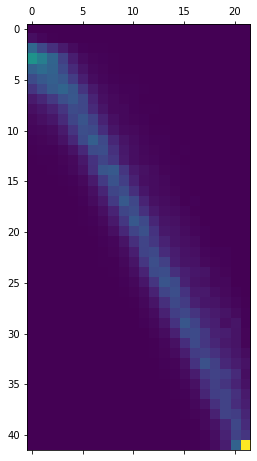

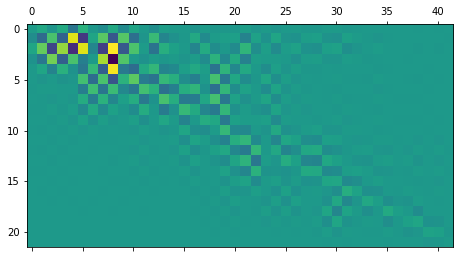

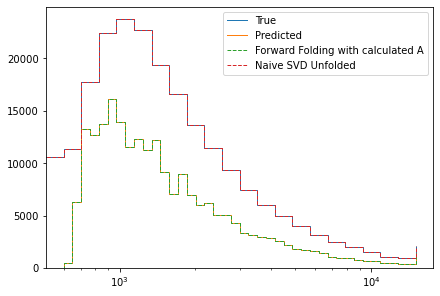

In [23]:
A, _, _ = np.histogram2d(test["gamma_energy_prediction"][gamma_test], test["corsika_event_header_total_energy"][gamma_test], bins=[bins_pred, bins_true])

A = A/np.sum(A,axis=0)
print(np.sum(A,axis=0)) # Check if normalized: should all be 1

g = A@hist_E_true # Should give the same histogram as hist_E_pred

A_inv = np.linalg.pinv(A,rcond=0)

f = A_inv@hist_E_pred

plt.matshow(A)
plt.matshow(A_inv)

fig, ax = plt.subplots(constrained_layout=True)

ax.stairs(hist_E_true,bins_E_true,label="True")
ax.stairs(hist_E_pred,bins_E_pred,label="Predicted")
ax.stairs(g,bins_E_pred,linestyle="--",label="Forward Folding with calculated A")
ax.stairs(f,bins_E_true,linestyle="--",label="Naive SVD Unfolded")

ax.set_xscale("log")
ax.legend(loc="best")

plt.show()

In [24]:
L=[]
f=np.empty(len(g))
for i in range(len(g)):
    L.append(lambda f: -g[i] * np.log(A[i]*f) + A[i]*f)
    f[i] = minimize(L[i], hist_E_true[i], method="Nelder-Mead", tol=1e-6)

print(f)

/home/uni/.local/conda/envs/smd_uebungen/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


ValueError: setting an array element with a sequence.

In [27]:
#E_C_pred = test["corsika_event_header_total_energy"][gamma_crab].to_numpy()
E_C_pred = crab["gamma_energy_prediction"][gamma_crab].to_numpy()

In [28]:
#hist_E_C_true, bins_E_true = np.histogram(E_C_true, bins_true)
hist_E_C_pred, bins_E_pred = np.histogram(E_C_pred, bins_pred)

In [33]:
f = A_inv@hist_E_pred

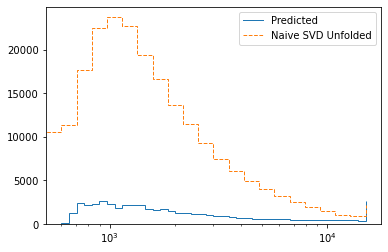

In [35]:
#plt.stairs(hist_E_C_true,bins_E_true,label="True")
plt.stairs(hist_E_C_pred,bins_E_pred,label="Predicted")
#plt.stairs(g,bins_E_pred,linestyle="--",label="Forward Folding with calculated A")
plt.stairs(f,bins_E_true,linestyle="--",label="Naive SVD Unfolded")

plt.xscale("log")
plt.legend(loc="best")

plt.show()

In [ ]:
for i in range(n_dim):
    L_poisson[i] = -g @ (A[:,i] / (A @ f)) + A[:,i].sum()